# Pryngles module: body 

In [1]:
from pryngles import *

## External modules

In [2]:
import spiceypy as spy
import numpy as np

## Aliases

In [3]:
sci=Science
print_df=Misc.print_df

## The body class

The Body class is one of the most important classes in the package. 

In [4]:
Body_doc=\
"""A general body.  This class is not intended to be used independently, just for inheritance purposes.
    
Initialization attributes:

    kind : string:
        One of the kind of bodies defined in the package (see _BODY_KINDS)
        Defined objects are: "Star", "Planet", "Ring".

    defaults : OrderedDict:
        Dictionary with the properties of the object.

    primary: Class Body:
        Object in the center of the orbit of this body.

    **properties: dicitionary:
        Specification of the body properties.  All objects of the class Body has the following
        properties by default:
        
        bhash: string, default = None:
            Hash of the object, ie. a unique string identifying the object 
            (see hash Python function)

        orbital properties: 
            Object with the orbital properties of the body (eg. orbit.m is the mass)
            see each specific Body definition for attributes.
            orbit must be compatible with rebound.

                m: float [rebound mass units], default = 1:
                    Mass of the body.  If m = 0 the body does not produce gravitation.

        physical properties:

            Object with the physical properties of the body (eg. physics.radius)
            see each specific Body definition for attributes.

                radius: float [rebound length units], default = 1:
                    Radius of the body.

                prot: float [ut], default = 1:
                    Period of rotation of the star.

                i: float [rad], default = 0:
                    Inclination of the body equator with respect to the ecliptic plane.

                roll: float [rad], default = 0:
                    Roll angle.  This is the angle with respect to ecliptic x-axis in which 
                    the normal to the object equatorial plane is rotated.

                alpha_equ: float [rad], default = 0:
                    Longitude of the zero meridian of the object.

                q0: float [ut], default = 0:
                    Initial longitude for zero meridian.

        optical properties:

            Object with the optical properties of the body (eg. physics.lamb_albedo)
            see each specific Body definition for attributes.

                nspangles: int, default = 1000:
                    Number of spangles on which the object will be discretized.
                    
                spangle_type: int, default = SOLID_SPANGLE:
                    Type of spangles of the body.
                    
                preset: boolean, default = True:
                    If True spangle object from a preset.

Derived attributes:

        wrot: float [rad/ut]:
            Rotational angular velocity.

        n_equ: array(3):
            Rotational axis vector in the ecliptic system.
    
Secondary attributes:

    childs: list
        List with child bodies (bodies which have this body) as the center.

Public methods:

    update_body(**props):
        Update a given set of properties.
        
Examples:

    Create a body with None parent and hash = 'B':
    
        B=Body("Body",BODY_DEFAULTS,None,hash='B',m=2,c=2)
        
    Create a body having parent the Body "B" defined before:
         
        C=Body("Body",BODY_DEFAULTS,B,hash="C")
"""

In [11]:
"""
These are the default attributes for any body.
"""
BODY_DEFAULTS=dict()
BODY_DEFAULTS.update(odict(
    
    bhash=None,
    
    #Orbit
    m=1,

    #Physics
    radius=1,
    prot=1,
    i=0, #Inclination of the rotational axis
    roll=0,
    alpha=0, #Zero meridian
    q0=0,
    
    #Optics
    nspangles=1000,
    spangle_type=SPANGLE_SOLID_ROCK,
    shape="sphere",
    geometry_args=dict(),
    seed=0,
    preset=True,
))

In [12]:
BODY_KINDS=[]
class Body(PrynglesCommon):
    
    def __init__(self,kind,defaults,primary,**props):

        #Kind, primary and child attributes
        self.kind=kind
        self.__defaults=defaults

        #Hash object
        if 'bhash' in props:
            bhash=self.bhash=str(props["bhash"])
        else:
            bhash=self.bhash=str(hash(self))

        #Update childs and parent
        if primary is not None:
            if not isinstance(primary,Body):
                raise AssertionError(f"Primary is not a valid Object: {type(primary)}, {isinstance(primary,Body)}")
            else:
                primary._update_childs(self)

        #Update primary and childs        
        self._update_primary(primary)
        self._update_childs()

        #Update default properties
        self.__dict__.update(defaults)
        #Recover hash
        self.bhash=bhash
        #Update body
        self.update_body(**props)
    
    def update_body(self,**props):
        """Update properties of the Body.
        
        Parametes:
            **props: dictionary:
                Properties to update. The current object is updated with new 
                values provided in this new object
                
        Example:
            B.update_body(m=2)
                This only update the attribute m of orbit.
        """
        for prop in props:
            if prop in self.__defaults or prop in REBOUND_ORBITAL_PROPERTIES:
                self.__dict__[prop]=props[prop]
            else:
                print(f"Property {prop} not identified in object {self.kind}")
                
        verbose(VERB_VERIFY,"Updating Body")
        self._update_properties()
    
    def _update_childs(self,child=None):
        if 'childs' not in self.__dict__:
            self.childs=dict()
        if child is not None:
            verbose(VERB_VERIFY,f"Add child {child.bhash} to body {self.kind} ({self.bhash})")
            self.childs[child.bhash]=child
            
    def _update_primary(self,primary=None):
        if 'primary' not in self.__dict__:
            if primary:
                verbose(VERB_VERIFY,f"Add primary {primary.bhash} to body {self.kind} ({self.bhash})")
            self.primary=primary
        elif primary is not None:
            verbose(VERB_VERIFY,f"Add parent {primary.bhash} to body {self.kind} ({self.bhash})")
            self.primary=primary
            parent._update_childs(self)
    
    def _update_properties(self):
        verbose(VERB_VERIFY,"Updating properties of Body")
        #Rotational angular velocity
        self.wrot=2*np.pi/self.prot
        #Rotation axis
        self.n_equ=sci.cartesian([1,self.roll,90*Consts.deg-self.i])

Body.__doc__=Body_doc

## Testing

In [41]:
if IN_JUPYTER:
    def test_fun(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        B=Body("Body",BODY_DEFAULTS,None,hash='B',m=2,c=2)
        
        print(B)
        print(B.m)
        
        B.update_body(hash="B")
        print(B)
        
        C=Body("Body",BODY_DEFAULTS,B,hash="C")
        print(C)
        print(B)
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_fun=test_fun
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

Property hash not identified in object Body
Property c not identified in object Body
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
{'kind': 'Body', 'bhash': '8780968900587', 'primary': None, 'childs': {}, 'm': 2, 'radius': 1, 'prot': 1, 'i': 0, 'roll': 0, 'alpha': 0, 'q0': 0, 'nspangles': 1000, 'spangle_type': 0, 'shape': 'sphere', 'geometry_args': {}, 'seed': 0, 'preset': True, 'wrot': 6.283185307179586, 'n_equ': array([6.123234e-17, 0.000000e+00, 1.000000e+00])}
2
Property hash not identified in object Body
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
{'kind': 'Body', 'bhash': '8780968900587', 'primary': None, 'childs': {}, 'm': 2, 'radius': 1, 'prot': 1, 'i': 0, 'roll': 0, 'alpha': 0, 'q0': 0, 'nspangles': 1000, 'spangle_type': 0, 'shape': 'sphere', 'geometry_args': {}, 'seed': 0, 'preset': True, 'wrot': 6.283185307179586, 'n_equ': array([6.123234e-17, 0.000000e+00, 1.0


----------------------------------------------------------------------
Ran 1 test in 0.089s

OK


In [26]:
def spangle_body(self):
    """
    Spangle the surface of the body
    """
    
    #Create spangler
    self.sg=Spangler(
        nspangles=self.nspangles,
        sphash=self.bhash,
        n_equ=self.n_equ,
        alpha_equ=self.alpha,
        w=self.wrot,
        q0=self.q0,
    )
    
    #Populate spangler
    self.sg.populate_spangler(
        shape=self.shape,
        spangle_type=self.spangle_type,
        scale=self.radius,
        seed=self.seed,
        preset=self.preset,
        **self.geometry_args,
    )

    self.sg.set_observer()
    self.sg.set_luz()

Body.spangle_body=spangle_body

Property hash not identified in object Body
Property c not identified in object Body
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [6.123234e-17 0.000000e+00 1.000000e+00]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [-1.000000e+00  0.000000e+00  6.123234e-17] [6.123234e-17 0.000000e+00 1.000000e+00]
      VERB3::set_positions:: Converting to equatorial
      VERB3::populate_spangler:: Populating spangler from preset for sphere
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
    VERB2::__init__:: Reading preset data from /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/src/pryngles/data/sampler_presets/sa

<IPython.core.display.Javascript object>


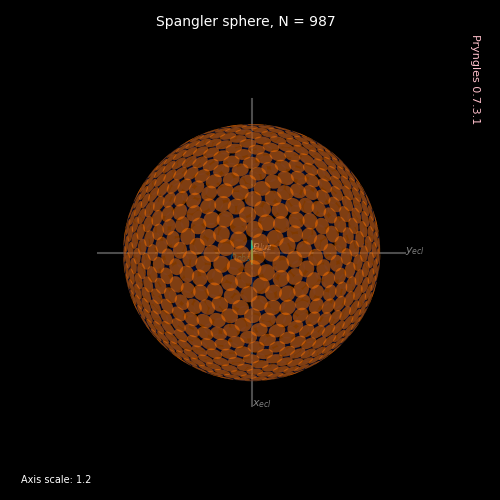

.
----------------------------------------------------------------------
Ran 1 test in 0.845s

OK


In [42]:
if IN_JUPYTER:
    def test_spangle(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        #Create body
        B=Body("Body",BODY_DEFAULTS,None,hash='B',m=2,c=2)
        B.spangle_body()
        B.sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_spangle=test_spangle
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Star Class

In [29]:
"""
These are the default attributes for bodies of the kind 'Star'.
"""
STAR_DEFAULTS=deepcopy(BODY_DEFAULTS)
STAR_DEFAULTS.update(odict(

    #Orbit: update
    #Same as Body
    
    #Physics: update
    #Same as Body
    
    #Optical properties: update
    limb_coeffs=[],
    spangle_type=SPANGLE_STELLAR,
    shape="sphere",
))

In [30]:
BODY_KINDS+=["Star"]
class Star(Body):
    """A star.

    Initialization attributes:
        
        primary: Class Body, default = None:
            Object in the center of the orbit of the star for specification purposes.

            If None the object is the center of the orbit specification for other objects.
            
            Object primary for a star should be another star.
        
        **props: dictionary:
            List of properties for star.  For the complete set of default values of the properties
            see STAR_DEFAULTS.  Description of properties are available in the Body class documentation.
            
            Additional properties:
            
                limb_coeffs: list [adimensional], default = []:
                    List of limb darkening fit coefficients.  See Science.calc_limbdarkening.

                    Models in: https://pages.jh.edu/~dsing3/David_Sing/Limb_Darkening.html
                    Coefficients available at: https://pages.jh.edu/~dsing3/LDfiles/LDCs.CoRot.Table1.txt
                    
                spangle_type: int, default = STAR_SPANGLE:
                    Type of spangles

    Derived attributes:
    
    Methods:
    
        update_body(**pars):

            This method compute some derived attributes like.

    Notes:

        See Body class documentation.
    
    """
    def __init__(self,
                 primary=None,
                 **props
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,"Star",STAR_DEFAULTS,primary,**props)

        #Check primary
        if self.primary is not None:
            if self.primary.kind!="Star":
                raise ValueError(f"Only another Star can be the primary of a Star (you provided {self.primary.kind})")

        self._update_star_properties()
        
    def _update_star_properties(self):
        """Update specific properties of the star
        
        Properties to update:
        
            norm_limb_darkening: float:
                Limb darkening function normalization.
                Requires: limb_coefs.

        """
        verbose(VERB_VERIFY,"Updating properties of Star")

        #Compute limbdarkening at r = 0 to initialize normalization constant
        sci.limb_darkening(0,self.limb_coeffs)
        
        #Store limb darkening normalization
        self.norm_limb_darkening=LIMB_NORMALIZATIONS[hash(tuple(self.limb_coeffs))]
        
    def update_star(self,**props):
        """General update propeties of the Star
        """
        verbose(VERB_VERIFY,"Updating star")
        
        Body.update_body(self,**props)
        self._update_star_properties()

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
{'kind': 'Star', 'bhash': '8780954319592', 'primary': None, 'childs': {}, 'm': 1, 'radius': 1, 'prot': 1, 'i': 0, 'roll': 0, 'alpha': 0, 'q0': 0, 'nspangles': 1000, 'spangle_type': 6, 'shape': 'sphere', 'geometry_args': {}, 'seed': 0, 'preset': True, 'limb_coeffs': [], 'wrot': 6.283185307179586, 'n_equ': array([6.123234e-17, 0.000000e+00, 1.000000e+00]), 'norm_limb_darkening': 3.141592653589793}
      VERB3::update_star:: Updating star
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
{'kind': 'Star', 'bhash': '8780954319592', 'primary': None, 'childs': {}, 'm': 2, 'radius': 1, 'prot': 1, 'i': 0, 'roll': 0, 'alpha': 0, 'q0': 0, 'nspangles': 1000, 'spangle_type': 6, 'shape': 'sphere', 'geometry_args': 

,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
283,8780968787137,6,1,1,"[0.7071067811865476, 0.0, 0.7071067811865475]",0,6.283185,0,"[0, 0, 0]",0.173663,-0.170121,0.970000,1.0,5.508088,1.325231,"[0.17366274780164015, -0.17012128034429888, 0.9700000000000002]","[0, 0, 0]",0.806187,0.173663,0.565600,"[0.8061874887065428, 0.17366274780164015, 0.5655996667953597]","[0.0, 0.0, 0.0]",0.806187,0.173663,0.565600,"[0.8061874887065428, 0.17366274780164015, 0.5655996667953597]",0.824680,0.212170,0.565600,0.565600,inf,-inf,"[0.0, 0.0, 0.0]",0.806187,0.173663,0.565600,"[0.8061874887065428, 0.17366274780164015, 0.5655996667953597]",0.824680,0.212170,0.565600,0.565600,inf,-inf,"[0.0, 0.0, 0.0]",0.806187,0.173663,0.565600,"[0.8061874887065428, 0.17366274780164015, 0.5655996667953597]",0.824680,0.212170,0.565600,0.565600,inf,-inf,0.043633,0.235702,1.0,0.0,False,False,False,True,False,False,False,False,False,True,False,False,False
284,8780968787137,6,1,1,"[0.7071067811865476, 0.0, 0.7071067811865475]",0,6.283185,0,"[0, 0, 0]",-0.011606,0.214447,0.976667,1.0,1.624866,1.354349,"[-0.01160642023720628, 0.21444699399035494, 0.9766666666666668]","[0, 0, 0]",0.538971,-0.011606,0.842245,"[0.5389706993032108, -0.01160642023720628, 0.8422445466145123]","[0.0, 0.0, 0.0]",0.538971,-0.011606,0.842245,"[0.5389706993032108, -0.01160642023720628, 0.8422445466145123]",0.539096,6.261654,0.842245,0.842245,inf,-inf,"[0.0, 0.0, 0.0]",0.538971,-0.011606,0.842245,"[0.5389706993032108, -0.01160642023720628, 0.8422445466145123]",0.539096,6.261654,0.842245,0.842245,inf,-inf,"[0.0, 0.0, 0.0]",0.538971,-0.011606,0.842245,"[0.5389706993032108, -0.01160642023720628, 0.8422445466145123]",0.539096,6.261654,0.842245,0.842245,inf,-inf,0.043633,0.235702,1.0,0.0,False,False,False,True,False,False,False,False,False,True,False,False,False
285,8780968787137,6,1,1,"[0.7071067811865476, 0.0, 0.7071067811865475]",0,6.283185,0,"[0, 0, 0]",-0.115387,-0.140504,0.983333,1.0,4.024829,1.387968,"[-0.11538747573594085, -0.14050368678025163, 0.9833333333333334]","[0, 0, 0]",0.794673,-0.115387,0.595971,"[0.7946727778707984, -0.11538747573594085, 0.5959705584627452]","[0.0, 0.0, 0.0]",0.794673,-0.115387,0.595971,"[0.7946727778707984, -0.11538747573594085, 0.5959705584627452]",0.803006,6.138992,0.595971,0.595971,inf,-inf,"[0.0, 0.0, 0.0]",0.794673,-0.115387,0.595971,"[0.7946727778707984, -0.11538747573594085, 0.5959705584627452]",0.803006,6.138992,0.595971,0.595971,inf,-inf,"[0.0, 0.0, 0.0]",0.794673,-0.115387,0.595971,"[0.7946727778707984, -0.11538747573594085, 0.5959705584627452]",0.803006,6.138992,0.595971,0.595971,inf,-inf,0.043633,0.235702,1.0,0.0,False,False,False,True,False,False,False,False,False,True,False,False,False
286,8780968787137,6,1,1,"[0.7071067811865476, 0.0, 0.7071067811865475]",0,6.283185,0,"[0, 0, 0]",0.139655,0.019909,0.990000,1.0,0.141607,1.429257,"[0.1396553364197865, 0.01990947034644173, 0.9900000000000002]","[0, 0, 0]",0.685958,0.139655,0.714114,"[0.6859575918828809, 0.1396553364197865, 0.7141138348664836]","[0.0, 0.0, 0.0]",0.685958,0.139655,0.714114,"[0.6859575918828809, 0.1396553364197865, 0.7141138348664836]",0.700030,0.200847,0.714114,0.714114,inf,-inf,"[0.0, 0.0, 0.0]",0.685958,0.139655,0.714114,"[0.6859575918828809, 0.1396553364197865, 0.7141138348664836]",0.700030,0.200847,0.714114,0.714114,inf,-inf,"[0.0, 0.0, 0.0]",0.685958,0.139655,0.714114,"[0.6859575918828809, 0.1396553364197865, 0.7141138348664836]",0.700030,0.200847,0.714114,0.714114,inf,-inf,0.043633,0.235702,1.0,0.0,F

  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, sphash = None
      VERB3::set_intersect:: Generating intersection matrices from pvec = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, sphash = None
      VERB3::set_intersect:: Generating intersection matrices from pvec = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]


<IPython.core.display.Javascript object>


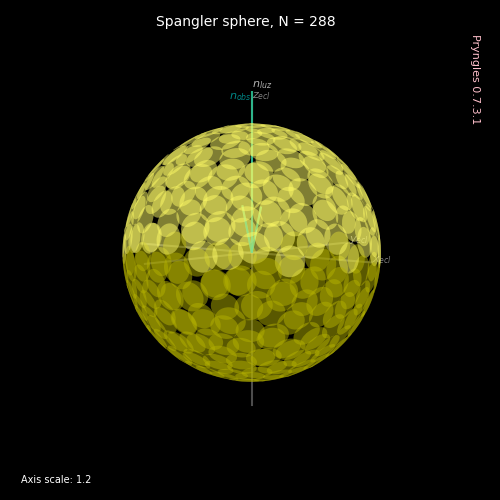

.
----------------------------------------------------------------------
Ran 1 test in 0.606s

OK


In [31]:
if IN_JUPYTER:
    def test_star(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        S=Star()
        print(S)

        #Check derived properties
        self.assertEqual(np.isclose([S.wrot],
                                    [2*np.pi/BODY_DEFAULTS["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        
        S.update_star(m=2,limb_coeffs=[1,1])
        print(S)
        
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Star(primary="Nada"))     
        
        S=Star(nspangles=270,i=45*Consts.deg)
        S.spangle_body()
        
        print_df(S.sg.data.tail())
        
        S.sg.set_observer()
        S.sg.set_luz()
        S.sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_star=test_star
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Planet class

In [32]:
"""
These are the default attributes for bodies of the kind 'Planet'.
"""
PLANET_DEFAULTS=deepcopy(BODY_DEFAULTS)
PLANET_DEFAULTS.update(odict(
    
    #Orbit: update
    #Same as Body
    a=1,
    e=0,
    
    #Physics: update
    #Same as Body
    
    #Optical: update
    spangle_type=SPANGLE_SOLID_ROCK,
    geometry="sphere",
    
    albedo_gray_spherical=1,
))

In [33]:
BODY_KINDS+=["Planet"]
class Planet(Body):
    """A planet.

    Initialization attributes:
        
        primary: Class Body, default = None:
            Object in the center of the orbit of the star for specification purposes.
            If None the object is the center of the orbit specification for other objects.

        **props: dictionary:
            List of properties for star.  For the complete set of default values of the properties
            see STAR_DEFAULTS.  Description of properties are available in the Body class documentation.
            
            Additional properties:
            
                a: float [ul], default = 1.0
                    Semi major axis of the orbit with respect to primary.

                e: float, default = 0.0
                    Eccentricity of the orbit with respect to primary.
        
    Derived attributes:
        None.
    
    Notes:

        See Body class documentation.
    
    """
    
    def __init__(self,
                 primary=None,
                 **props
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,"Planet",PLANET_DEFAULTS,primary,**props)
        
        #Check primary
        if self.primary is None:
            raise ValueError(f"Primary not provided and it is mandatory for {self.kind}.")
        
        #Update properties
        self.update_planet(**props)

    def _update_planet_properties(self):
        """Update specific properties of the star
        
        Properties to update:
        
            norm_limb_darkening: float:
                Limb darkening function normalization.
                Requires: limb_coefs.

        """
        verbose(VERB_VERIFY,"Updating Planet properties")
        
        #Semilatus rectum
        self.p=self.a*(1-self.e**2)

    def update_planet(self,**pars):
        verbose(VERB_VERIFY,"Updating Planet")
        Body.update_body(self,**pars)
        self._update_planet_properties()

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_childs:: Add child 8780988541787 to body Star (8780988943888)
      VERB3::_update_primary:: Add primary 8780988943888 to body Planet (8780988541787)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
8780988541787
      VERB3::update_planet:: Updating Planet
Property rho not identified in object Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_pr

,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
194,8780988541787,0,1,1,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",0.280805,-0.095518,0.955,1.0,5.955305,1.269660,"[0.28080478278493565, -0.09551792483667675, 0.9550000000000001]","[0, 0, 0]",0.095518,0.280805,0.955,"[0.0955179248366768, 0.28080478278493565, 0.9550000000000001]","[0.0, 0.0, 0.0]",0.095518,0.280805,0.955,"[0.0955179248366768, 0.28080478278493565, 0.9550000000000001]",0.296606,1.242916,0.955,0.955,inf,-inf,"[0.0, 0.0, 0.0]",0.095518,0.280805,0.955,"[0.0955179248366768, 0.28080478278493565, 0.9550000000000001]",0.296606,1.242916,0.955,0.955,inf,-inf,"[0.0, 0.0, 0.0]",0.095518,0.280805,0.955,"[0.0955179248366768, 0.28080478278493565, 0.9550000000000001]",0.296606,1.242916,0.955,0.955,inf,-inf,0.063148,0.283552,1.0,0.0,False,False,False,True,False,False,False,False,False,True,False,False,False
195,8780988541787,0,1,1,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",-0.126025,0.229984,0.965,1.0,2.072083,1.305443,"[-0.12602538251072315, 0.22998391892266234, 0.9650000000000001]","[0, 0, 0]",-0.229984,-0.126025,0.965,"[-0.2299839189226623, -0.12602538251072315, 0.9650000000000001]","[0.0, 0.0, 0.0]",-0.229984,-0.126025,0.965,"[-0.2299839189226623, -0.12602538251072315, 0.9650000000000001]",0.262250,3.642880,0.965,0.965,inf,-inf,"[0.0, 0.0, 0.0]",-0.229984,-0.126025,0.965,"[-0.2299839189226623, -0.12602538251072315, 0.9650000000000001]",0.262250,3.642880,0.965,0.965,inf,-inf,"[0.0, 0.0, 0.0]",-0.229984,-0.126025,0.965,"[-0.2299839189226623, -0.12602538251072315, 0.9650000000000001]",0.262250,3.642880,0.965,0.965,inf,-inf,0.063148,0.283552,1.0,0.0,False,False,False,True,False,False,False,False,False,True,False,False,False
196,8780988541787,0,1,1,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",-0.052893,-0.215818,0.975,1.0,4.472047,1.346721,"[-0.052892584597813236, -0.2158179197716515, 0.9750000000000001]","[0, 0, 0]",0.215818,-0.052893,0.975,"[0.21581791977165155, -0.052892584597813236, 0.9750000000000001]","[0.0, 0.0, 0.0]",0.215818,-0.052893,0.975,"[0.21581791977165155, -0.052892584597813236, 0.9750000000000001]",0.222205,6.042843,0.975,0.975,inf,-inf,"[0.0, 0.0, 0.0]",0.215818,-0.052893,0.975,"[0.21581791977165155, -0.052892584597813236, 0.9750000000000001]",0.222205,6.042843,0.975,0.975,inf,-inf,"[0.0, 0.0, 0.0]",0.215818,-0.052893,0.975,"[0.21581791977165155, -0.052892584597813236, 0.9750000000000001]",0.222205,6.042843,0.975,0.975,inf,-inf,0.063148,0.283552,1.0,0.0,False,False,False,True,False,False,False,False,False,True,False,False,False
197,8780988541787,0,1,1,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",0.143495,0.095834,0.985,1.0,0.588824,1.397374,"[0.1434951743233927, 0.09583389246972551, 0.9850000000000001]","[0, 0, 0]",-0.095834,0.143495,0.985,"[-0.09583389246972546, 0.1434951743233927, 0.9850000000000001]","[0.0, 0.0, 0.0]",-0.095834,0.143495,0.985,"[-0.09583389246972546, 0.1434951743233927, 0.9850000000000001]",0.172554,2.159621,0.985,0.985,inf,-inf,"[0.0, 0.0, 0.0]",-0.095834,0.143495,0.985,"[-0.09583389246972546, 0.1434951743233927, 0.9850000000000001]",0.172554,2.159621,0.985,0.985,inf,-inf,"[0.0, 0.0, 0.0]",-0.095834,0.143495,0.985,"[-0.09583389246972546, 0.1434951743233927, 0.9850000000000001]",0.172554,2.159621,0.985,0.985,inf,-inf,0.063148,0.283552,1.0,0.0,False,False,False,True,False,False,False,False,False,True,False,False,False
198,8780988541787,0,1,1,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0,

<IPython.core.display.Javascript object>


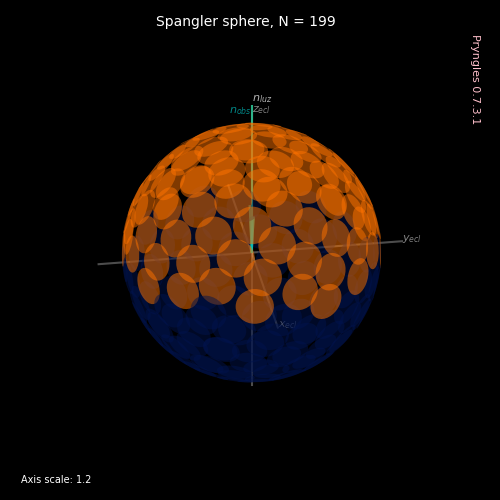

.
----------------------------------------------------------------------
Ran 1 test in 0.553s

OK


In [35]:
if IN_JUPYTER:
    def test_planet(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        S=Star()

        #Check exception: primary is mandatory for planets
        self.assertRaises(ValueError,lambda:Planet())

        P=Planet(primary=S)
        print(P.bhash)
        
        #Check derived properties
        self.assertEqual(np.isclose([P.wrot],
                                    [2*np.pi/BODY_DEFAULTS["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        
        #Check a non-existing property
        P.update_planet(a=5,e=0.5,rho=0.2)
        print(P)
        
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Planet(primary="Nada"))
        
        P.update_body(nspangles=250)
        P.spangle_body()
        print_df(P.sg.data.tail())
        
        P.sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass    
    Test.test_planet=test_planet
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Ring class

In [37]:
RING_DEFAULTS=deepcopy(BODY_DEFAULTS)
RING_DEFAULTS.update(odict(

    #Orbit: update
    #Same as Body altough ring has not orbit properties
    
    #Physics: update
    #Same as Body
    fi=1.0,
    fe=2.0,
    
    #Optics: update
    spangle_type=SPANGLE_GRANULAR,
    shape="ring",
    albedo_gray_normal=1,
    tau_gray_optical=0,
))

## Ring Class

In [38]:
BODY_KINDS+=["Ring"]

class Ring(Body):
    """Class Ring.
    
Initialization attributes:
        
        primary: Class Body, default = None:
            Object in the center of the orbit of the star for specification purposes.
            If None the object is the center of the orbit specification for other objects.

        **props: dictionary:
            List of properties for star.  For the complete set of default values of the properties
            see STAR_DEFAULTS.  Description of properties are available in the Body class documentation.
            
            Additional properties:

            fi: float [adimensional], default = 1:
                Fraction of the radius of the primary object where ring stars.

            fe: float [adimensional], default = 1:
                Fraction of the radius of the primary object where ring ends.

            albedo_gray_normal: float. default = 1: 
                Lambertian (normal) gray (wavelength indpendent) albedo of the spangle.

            tau_gray_optical: float. default = 0:
                Gray (wavelength indpendent) Optical depth of the spangle.  
                If 0 the spangle is entirely opaque to all wavelength, despite its type.            

    Derived attributes:
    
        ri: float:
            Radius of the inner border of the ring in units of the primary radius.

        re: float:
            Radius of the outer border of the ring in units of the primary radius.
            
    Notes:

        See Body class documentation.
    """
    def __init__(self,
                 primary=None,
                 **props
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,"Ring",RING_DEFAULTS,primary,**props)
        
        #Check primary
        if self.primary is None:
            raise ValueError(f"Primary not provided and mandatory for {self.kind}.")
        
        #Update properties
        self.update_ring(**props)

    def _update_ring_properties(self):
        """Update specific properties of the star
        
        Properties to update:
        
            ri, re: float:
                Radius of the inner (outer) border of the ring in units of the primary radius.
                Requires: limb_coefs.
                
            radius: float:
                Object radius.
                
            geometry_args: dictionary:
                
        """
        verbose(VERB_VERIFY,"Updating Ring properties")
    
        #Update radius
        self.ri=self.fi*self.primary.radius
        self.re=self.fe*self.primary.radius
        self.radius=self.re
        
        #Update geometry args for spangling purposes
        self.geometry_args=dict(ri=self.ri/self.re)
        
    def update_ring(self,**pars):
        verbose(VERB_VERIFY,"Updating Ring")
        Body.update_body(self,**pars)
        self._update_ring_properties()   

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::_update_childs:: Add child 8780953678596 to body Star (8780953678713)
      VERB3::_update_primary:: Add primary 8780953678713 to body Planet (8780953678596)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_childs:: Add child 8780988555731 to body Planet (8780953678596)
      VERB3::_update_primary:: Add primary 8780953678596 to body Ring (8780988555731)
      VERB3::update_body:: Updating Body
      VERB3::_update_prop

,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
289,8780988555731,4,0,3,"[0.8660254037844386, 0.0, 0.5]",0,6.283185,0,"[0, 0, 0]",0.500000,-8.660254e-01,0.0,1.0,5.235988,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",4.330127e-01,0.500000,-7.500000e-01,"[0.8660254037844386, 0.0, 0.5]","[0.0, 0.0, 0.0]",4.330127e-01,0.500000,-7.500000e-01,"[0.8660254037844386, 0.0, 0.5]",0.661438,0.857072,-7.500000e-01,0.5,inf,-inf,"[0.0, 0.0, 0.0]",4.330127e-01,0.500000,-7.500000e-01,"[0.8660254037844386, 0.0, 0.5]",0.661438,0.857072,-7.500000e-01,0.5,inf,-inf,"[0.0, 0.0, 0.0]",4.330127e-01,0.500000,-7.500000e-01,"[0.8660254037844386, 0.0, 0.5]",0.661438,0.857072,-7.500000e-01,0.5,inf,-inf,0.09343,0.344904,1.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False
290,8780988555731,4,0,3,"[0.8660254037844386, 0.0, 0.5]",0,6.283185,0,"[0, 0, 0]",0.707107,-7.071068e-01,0.0,1.0,5.497787,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",3.535534e-01,0.707107,-6.123724e-01,"[0.8660254037844386, 0.0, 0.5]","[0.0, 0.0, 0.0]",3.535534e-01,0.707107,-6.123724e-01,"[0.8660254037844386, 0.0, 0.5]",0.790569,1.107149,-6.123724e-01,0.5,inf,-inf,"[0.0, 0.0, 0.0]",3.535534e-01,0.707107,-6.123724e-01,"[0.8660254037844386, 0.0, 0.5]",0.790569,1.107149,-6.123724e-01,0.5,inf,-inf,"[0.0, 0.0, 0.0]",3.535534e-01,0.707107,-6.123724e-01,"[0.8660254037844386, 0.0, 0.5]",0.790569,1.107149,-6.123724e-01,0.5,inf,-inf,0.09343,0.344904,1.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False
291,8780988555731,4,0,3,"[0.8660254037844386, 0.0, 0.5]",0,6.283185,0,"[0, 0, 0]",0.866025,-5.000000e-01,0.0,1.0,5.759587,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",2.500000e-01,0.866025,-4.330127e-01,"[0.8660254037844386, 0.0, 0.5]","[0.0, 0.0, 0.0]",2.500000e-01,0.866025,-4.330127e-01,"[0.8660254037844386, 0.0, 0.5]",0.901388,1.289761,-4.330127e-01,0.5,inf,-inf,"[0.0, 0.0, 0.0]",2.500000e-01,0.866025,-4.330127e-01,"[0.8660254037844386, 0.0, 0.5]",0.901388,1.289761,-4.330127e-01,0.5,inf,-inf,"[0.0, 0.0, 0.0]",2.500000e-01,0.866025,-4.330127e-01,"[0.8660254037844386, 0.0, 0.5]",0.901388,1.289761,-4.330127e-01,0.5,inf,-inf,0.09343,0.344904,1.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False
292,8780988555731,4,0,3,"[0.8660254037844386, 0.0, 0.5]",0,6.283185,0,"[0, 0, 0]",0.965926,-2.588190e-01,0.0,1.0,6.021386,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1.294095e-01,0.965926,-2.241439e-01,"[0.8660254037844386, 0.0, 0.5]","[0.0, 0.0, 0.0]",1.294095e-01,0.965926,-2.241439e-01,"[0.8660254037844386, 0.0, 0.5]",0.974556,1.437615,-2.241439e-01,0.5,inf,-inf,"[0.0, 0.0, 0.0]",1.294095e-01,0.965926,-2.241439e-01,"[0.8660254037844386, 0.0, 0.5]",0.974556,1.437615,-2.241439e-01,0.5,inf,-inf,"[0.0, 0.0, 0.0]",1.294095e-01,0.965926,-2.241439e-01,"[0.8660254037844386, 0.0, 0.5]",0.974556,1.437615,-2.241439e-01,0.5,inf,-inf,0.09343,0.344904,1.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False
293,8780988555731,4,0,3,"[0.8660254037844386, 0.0, 0.5]",0,6.283185,0,"[0, 0, 0]",1.000000,-2.449294e-16,0.0,1.0,6.283185,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1.224647e-16,1.000000,-2.121150e-16,"[0.8660254037844386, 0.0, 0.5]","[0.0, 0.0, 0.0]",1.224647e-16,1.000000,-2.121150e-16,"[0.8660254037844386, 0.0, 0.5]",1.000000,1.570796,-2.121150e-16,0.5,inf,-inf,"[0.0, 0.0, 0.0]",1.224647e-16,1.000000,-2.121150e-16,"[0.8660254037844386, 0.0, 0.5]",1.000000,1.570796,-2.121150e-16,0.5,inf,-inf,"[0.0, 0.0, 0.0]",1.224647e-16,1.000000,-2.121150e-16,"[0.8660254037844386,

<IPython.core.display.Javascript object>


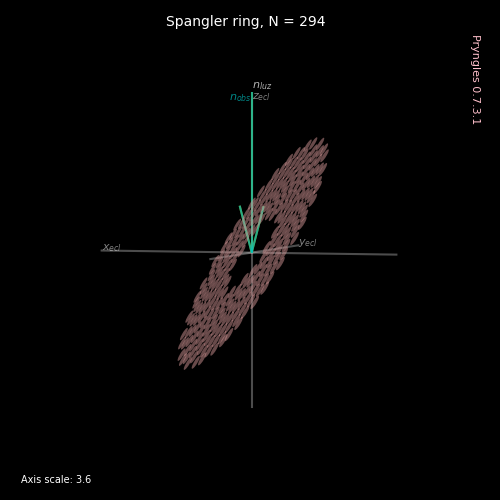

.
----------------------------------------------------------------------
Ran 1 test in 0.772s

OK


In [39]:
if IN_JUPYTER:
    def test_ring(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        #Define first star and planet
        S=Star()
        P=Planet(primary=S)

        self.assertRaises(ValueError,lambda:Ring())
        R=Ring(primary=P)
        
        R.update_ring(fe=3)
        print(R)
        
        R.update_body(nspangles=250,i=60*Consts.deg,roll=0*Consts.deg)
        R.spangle_body()
        print_df(R.sg.data.tail())
        R.sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass    
    Test.test_ring=test_ring
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--